# Метрики

## Imports

In [1]:
import pandas as pd
import numpy as np
import numba as nb
import requests
from tqdm import tqdm
from rectools import Columns
import matplotlib.pyplot as plt
import time
import zipfile as zf
from urllib.parse import urlencode

In [3]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'

In [4]:
req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download: 100%|█████████▉| 78.6M/78.8M [00:00<00:00, 167MiB/s]

In [5]:
files = zf.ZipFile('kion.zip','r')
files.extractall()
files.close()

In [6]:
np.random.seed(23)

## Read data

In [6]:
interactions = pd.read_csv('../../data/interactions.csv')

interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    },
    inplace=True)

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [8]:
users = pd.read_csv('/content/data_original/users.csv')
items = pd.read_csv('/content/data_original/items.csv')

In [8]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']

    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

## Homework

### PFound
Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

$$pBreak = 0.15$$

**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)

In [10]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://yadi.sk/d/guqki4UI4hFlXQ'


final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('./data.zip', 'wb') as f:
    f.write(download_response.content)

In [ ]:
!unzip data.zip
!unzip hidden_task.zip
!unzip open_task.zip

## Pfound

In [12]:
# Считываем данные
qid_query = pd.read_csv("qid_query.tsv", sep="\t", names=["qid", "query"])
qid_url_rating = pd.read_csv("qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv("hostid_url.tsv", sep="\t", names=["hostid", "url"])

# Делаем join двух таблиц, чтобы было просто брать url с максимальным рейтингом
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")

In [13]:
qid_query.head(3) #  id запроса и текст запроса, разделённые табуляцией

,qid,query
0,402111,работа фотографом в австралии
1,405851,производительность видеокарт
2,407522,ёлочные игрушки из пластиковых бутылок


In [14]:
qid_url_rating.head(3) # id запроса, URL документа, релевантность документа запросу

,qid,url,rating
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07
2,402111,http://802351.info/5964-v-avstralii.html,0.00


In [15]:
hostid_url.head(3) # id хоста и URL документа

,hostid,url
0,1,http://09spravki.ru/requisites.php
1,10,http://3pu.info/seo-tools/domains
2,1006,http://www.priroda.su/item/820


In [16]:
qid_url_rating_hostid.head(3)

,qid,url,rating,hostid
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
2,402111,http://802351.info/5964-v-avstralii.html,0.00,13


In [17]:
def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)


def pfound(group):
    max_by_host = group.groupby("hostid")["rating"].max() # Максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # Берем топ10 урлов с наивысшим рейтингом
    pfound = 0
    for ind, val in enumerate(top10):
        pfound += val*plook(ind, top10.values)
    return pfound


qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound) # Группируем по qid и вычисляем pfound
qid_max = qid_pfound.idxmax() # Берем qid с максимальным pfound

qid_query[qid_query["qid"] == qid_max]

,qid,query
14,692308,бесплатный просмотр камеди клаб


In [18]:
avg_pfound_original = qid_pfound.mean()
print(f'Средний pFound по всем query (расчет с сайта): {avg_pfound_original}')

Средний pFound по всем query (расчет с сайта): 0.5822199638393889


In [19]:
def fast_PFoundK(qid_url_rating_hostid, K=10, p_break=0.15):
    """
    Подсчет метрики PFound@K
    """
    # Получаем максимальный рейтинг для кажого url, и потом сортируем
    max_by_host = qid_url_rating_hostid.groupby(['qid', 'hostid'])['rating'].max().reset_index()
    top = max_by_host.sort_values(['qid', 'rating'], ascending=False).groupby(['qid']).head(K)

    top['rank'] = top.groupby('qid').cumcount()  # Задаем порядок для отсортированного рейтинга
    # Ниже идут вспомогательные операции для подсчета метрики
    top['one_minus_rating'] = (1 - top['rating']).shift(1)
    top['p_break'] = 1 - p_break
    top.loc[top['rank'] == 0, ['p_break', 'one_minus_rating']] = 1

    top['temp_with_mult'] = top['one_minus_rating'] * top['p_break']

    top['plook'] = top.groupby('qid')['temp_with_mult'].cumprod()
    top['pfound'] = top['plook'] * top['rating']

    pfound_qid = top.groupby('qid')['pfound'].sum() # Подсчет pFound
    return pfound_qid.mean()

In [20]:
print(fast_PFoundK(qid_url_rating_hostid))

0.5822199638393889


##MRR

### MRR
Исходные данные - результат `generate_subsample`

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

In [9]:
# Генерация данных
top_k = 10
df, users, recs = generate_subsample(10000, top_k)
target = df.values

In [46]:
def mrr_pandas(df, users, recs, top_k):
    # Формируем датасет
    df_r = pd.DataFrame({
        Columns.User: np.repeat(users, top_k), # Повторяем user_id к раз
        Columns.Item: recs.ravel() # Вытягиваем все рекомендации в 1 общий массив
    })
    # Составляем ранги
    df_r[Columns.Rank] = df_r.groupby(Columns.User).cumcount() + 1
    # Делаем джоин, чтобы понять ранги рекомендаций, которые были предсказаны верно
    df_r = df_r.merge(df, how='right', left_on=Columns.UserItem,
                      right_on=Columns.UserItem)
    # 1/rank(i)
    df_r['revert_rank'] =  1 / df_r[Columns.Rank]
    # Заполняем нулями пропуски
    df_r['revert_rank'] = df_r['revert_rank'].fillna(0)
    # Считаем итоговую формулу
    mrr = df_r['revert_rank'].sum() / (top_k * len(users))
    return mrr

In [47]:
mrr_pandas(df, users, recs, 10)

0.008886333333333333

In [48]:
def mrr_naive(df, users, recs, k):
    mrp = []
    for i, j in enumerate(users):
        mrp_value = 0
        # Находим список item_id у юзера
        user_target = list(df[df[Columns.User] == j][Columns.Item])
        # Далее проходим по каждой рекомендации для юзера
        for rank, rec in enumerate(recs[i]):
            # Проверяем, взаимодействовал ли этот пользователь с рекомендацией
            if rec in user_target:
                # Если да, то делаем 1/rank и суммируем
                mrp_value += 1 / (rank + 1)
        mrp.append(mrp_value / k)

    return sum(mrp) / len(users)

In [49]:
mrr_naive(df, users, recs, 10)

0.004131396103896114

In [25]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target, users, recs, k):
    mrp = np.zeros(len(users))
    for i in nb.prange(len(users)):
        mrp_value = 0
        # Находим список item_id у юзера
        user_target = target[target[:, 0] == users[i]][:, 1]
        # Далее проходим по каждой рекомендации для юзера
        for rank in nb.prange(len(recs[i])):
          # Проверяем, взаимодействовал ли этот пользователь с рекомендацией
            if  recs[i][rank] in user_target:
                mrp_value += 1 / (rank + 1)
        mrp[i] = mrp_value / k
    return mrp.mean()

In [ ]:
mrr_numba(target, users, recs, 10)

0.00915422222222224

In [ ]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
time_pandas = []
time_naive = []
time_numba = []
for user in tqdm(users_count):
  for k in top_k:
    df, users, recs = generate_subsample(user, k)
    target = df.values
    start_time = time.time()
    mrr_pandas(df, users, recs, k)
    time_pandas.append((time.time() - start_time))
    start_time = time.time()
    mrr_naive(df, users, recs, k)
    time_naive.append((time.time() - start_time))
    start_time = time.time()
    mrr_numba(target, users, recs, k)
    time_numba.append((time.time() - start_time))

In [27]:
time_pandas

[0.006612539291381836,
 0.007052183151245117,
 0.011492729187011719,
 0.009406089782714844,
 0.02314591407775879,
 0.02467036247253418,
 0.08337664604187012,
 0.12069916725158691,
 0.21112680435180664,
 0.44942188262939453,
 2.0020482540130615,
 4.374759674072266]

In [28]:
time_naive

[0.037677764892578125,
 0.04435467720031738,
 0.05887031555175781,
 0.4026973247528076,
 0.47898054122924805,
 0.6203315258026123,
 6.508265256881714,
 4.798636436462402,
 5.278609991073608,
 92.38966774940491,
 95.74640965461731,
 104.32804203033447]

In [35]:
time_numba

[0.000247757532131,
 0.0003657341003417969,
 0.004538297653198242,
 0.011430025100708008,
 0.011219501495361328,
 0.05763840675354004,
 1.0970313549041748,
 1.1326920986175537,
 1.121244192123413,
 114.41677212715149,
 115.22078323364258,
 114.80799078941345]

In [36]:
# Возьмем логарифм времени, чтобы избавиться от больших значений
time_naive_lg = np.log(np.array(time_naive)).reshape((4, 3))
time_numba_lg = np.log(np.array(time_numba)).reshape((4, 3))

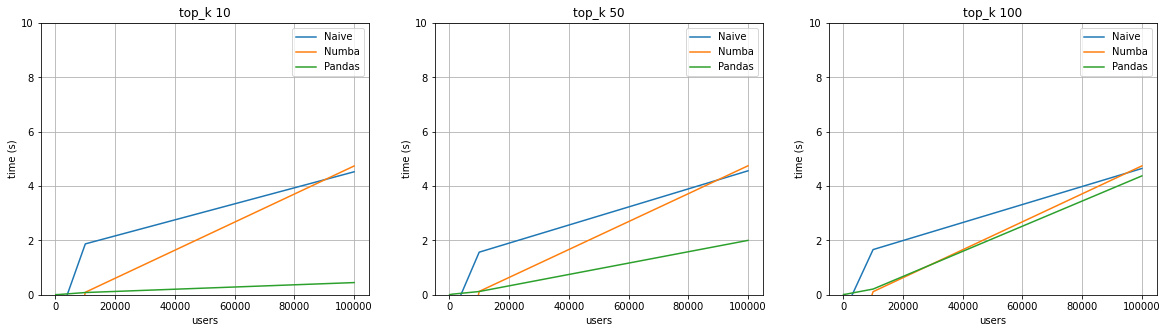

In [37]:
_, ax = plt.subplots(1,3, figsize=(20,5))
for i in range(3):
    ax[i].plot(users_count, time_naive_lg[:,i], label='Naive')
    ax[i].plot(users_count, time_numba_lg[:,i], label='Numba')
    ax[i].plot(users_count, time_pandas[:,i], label='Pandas')
    ax[i].set_title(f'top_k {top_k[i]}')
    ax[i].set_xlabel('users')
    ax[i].set_ylabel('time (s)')
    ax[i].set_ylim(0, 10)
    ax[i].grid()
    ax[i].legend()
plt.show()
